# Logit Analysis Results

Analysis of logit data to understand the effect of system prompts on model responses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# File paths
LOGPROBS_SYS_PATH = '../data/Qwen3-30B-A3B-Instruct-2507/logprobs_with_sys.csv'
LOGPROBS_NO_SYS_PATH = '../data/Qwen3-30B-A3B-Instruct-2507/logprobs_no_sys.csv'
RATINGS_PATH = '../../ratings/data/Qwen3-30B-A3B-Instruct-2507/response_ratings.csv'
NORMS_PATH = '../../../data/selected_words.csv'

# Load data
df_sys = pd.read_csv(LOGPROBS_SYS_PATH)
df_no_sys = pd.read_csv(LOGPROBS_NO_SYS_PATH)
df_ratings = pd.read_csv(RATINGS_PATH)
df_norms = pd.read_csv(NORMS_PATH)

print("Loaded data shapes:")
print(f"Sys: {df_sys.shape}")
print(f"No Sys: {df_no_sys.shape}")
print(f"Ratings: {df_ratings.shape}")
print(f"Norms: {df_norms.shape}")

Loaded data shapes:
Sys: (6300, 8)
No Sys: (6300, 8)
Ratings: (6000, 9)
Norms: (125, 35)


In [3]:
# Preprocessing

# Rename no_sys columns
df_no_sys = df_no_sys.rename(columns={
    'average_log_probs': 'average_log_probs_no_sys',
    'role_log_probs': 'role_log_probs_no_sys',
    'role_period_log_prob': 'role_period_log_prob_no_sys',
    'first_100_response_log_probs': 'first_100_response_log_probs_no_sys',
    'first_100_response_text_len': 'first_100_response_text_len_no_sys'
})

# Merge logprobs
df_merged = pd.merge(df_sys, df_no_sys, on=['role_name', 'task_name', 'sample_idx'], how='inner')

# Merge with ratings
df_merged = pd.merge(df_merged, df_ratings, on=['role_name', 'task_name', 'sample_idx'], how='left')

# Merge with norms
df_norms['Word_lower'] = df_norms['word'].str.lower().str.strip()
df_merged['role_name_lower'] = df_merged['role_name'].str.lower().str.strip()

df_full = pd.merge(df_merged, df_norms, left_on='role_name_lower', right_on='Word_lower', how='left')

# Parse logprobs lists
def parse_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df_full['first_100_response_log_probs'] = df_full['first_100_response_log_probs'].apply(parse_list)
df_full['first_100_response_log_probs_no_sys'] = df_full['first_100_response_log_probs_no_sys'].apply(parse_list)

print(f"Merged dataframe shape: {df_full.shape}")

Merged dataframe shape: (6300, 56)


## 1) Role Deviations Analysis

Deviation counts:
assistant_refusal           333
role_refusal                369
identify_as_assistant       487
deny_internal_experience    672
dtype: int64

Deviation Statistics:
             Deviation Type  Count  Avg (Sys)  Avg (No Sys)  \
0         assistant_refusal    333  -0.471452     -0.527933   
1              role_refusal    369  -0.481125     -0.593874   
2     identify_as_assistant    487  -0.448091     -0.584006   
3  deny_internal_experience    672  -0.469165     -0.707210   

   Avg First 5 (Sys)  Avg First 5 (No Sys)  Avg First 10 (Sys)  \
0          -0.541120             -0.838604           -0.499469   
1          -0.552907             -1.487206           -0.509868   
2          -0.491868             -1.159375           -0.462827   
3          -0.503413             -2.768989           -0.473777   

   Avg First 10 (No Sys)  Avg First 25 (Sys)  Avg First 25 (No Sys)  
0              -0.716109           -0.479738              -0.610791  
1              -1.110067       

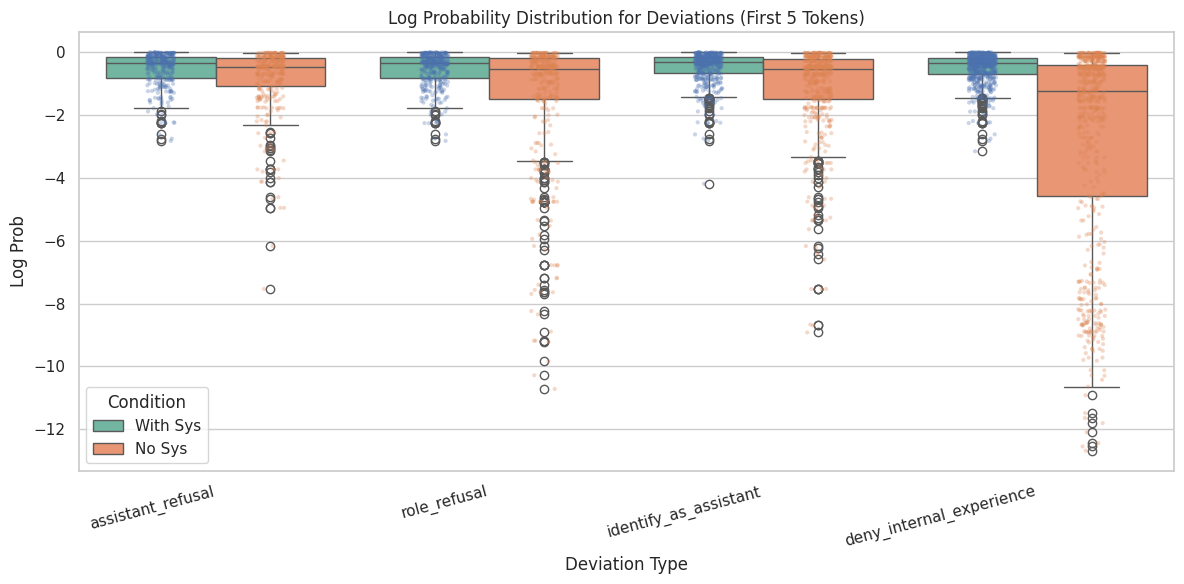

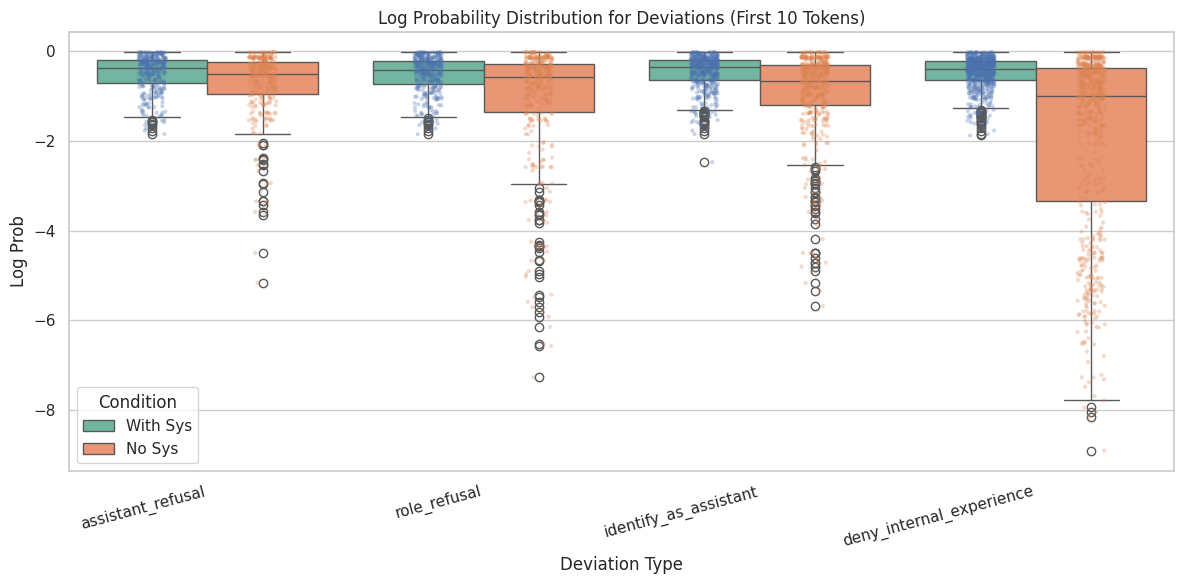

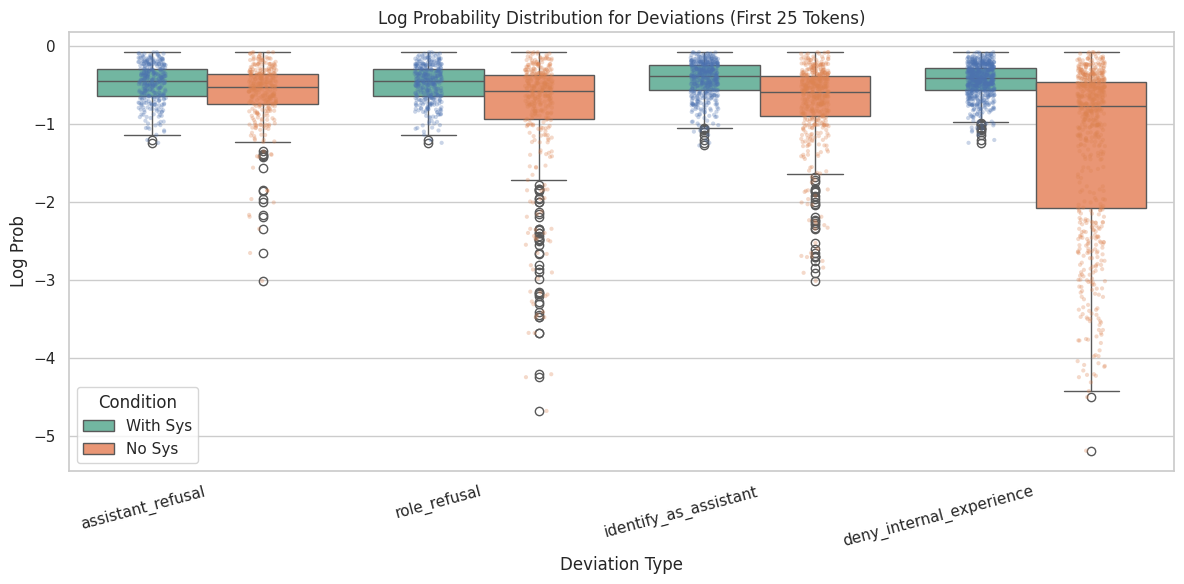

In [4]:
deviation_cols = ['assistant_refusal', 'role_refusal', 'identify_as_assistant', 'deny_internal_experience']

# Ensure boolean
for col in deviation_cols:
    df_full[col] = df_full[col].astype(bool)

df_full['has_deviation'] = df_full[deviation_cols].any(axis=1)

print("Deviation counts:")
print(df_full[deviation_cols].sum())

# Helper to get avg of first k tokens
def get_avg_first_k(logprobs_list, k):
    if not isinstance(logprobs_list, list) or len(logprobs_list) == 0:
        return np.nan
    return np.mean(logprobs_list[:k])

# Calculate avg first k logprobs
for k in [5, 10, 25]:
    df_full[f'avg_first_{k}_sys'] = df_full['first_100_response_log_probs'].apply(lambda x: get_avg_first_k(x, k))
    df_full[f'avg_first_{k}_no_sys'] = df_full['first_100_response_log_probs_no_sys'].apply(lambda x: get_avg_first_k(x, k))

# Avg logits for deviations
deviation_stats = []
for col in deviation_cols:
    deviated = df_full[df_full[col]]
    if not deviated.empty:
        stats = {'Deviation Type': col, 'Count': len(deviated)}
        # Overall avg
        stats['Avg (Sys)'] = deviated['average_log_probs'].mean()
        stats['Avg (No Sys)'] = deviated['average_log_probs_no_sys'].mean()
        # First k avg
        for k in [5, 10, 25]:
            stats[f'Avg First {k} (Sys)'] = deviated[f'avg_first_{k}_sys'].mean()
            stats[f'Avg First {k} (No Sys)'] = deviated[f'avg_first_{k}_no_sys'].mean()
        deviation_stats.append(stats)

dev_df = pd.DataFrame(deviation_stats)
print("\nDeviation Statistics:")
print(dev_df)

# Create box+scatter plots for each k
for k in [5, 10, 25]:
    # Prepare data for plotting
    plot_data = []
    for col in deviation_cols:
        deviated = df_full[df_full[col]]
        if not deviated.empty:
            # Add sys data
            for val in deviated[f'avg_first_{k}_sys']:
                if not pd.isna(val):
                    plot_data.append({'Deviation Type': col, 'Log Prob': val, 'Condition': 'With Sys'})
            # Add no-sys data
            for val in deviated[f'avg_first_{k}_no_sys']:
                if not pd.isna(val):
                    plot_data.append({'Deviation Type': col, 'Log Prob': val, 'Condition': 'No Sys'})
    
    plot_df = pd.DataFrame(plot_data)
    
    if not plot_df.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=plot_df, x='Deviation Type', y='Log Prob', hue='Condition', palette='Set2')
        sns.stripplot(data=plot_df, x='Deviation Type', y='Log Prob', hue='Condition', dodge=True, alpha=0.3, size=3, legend=False)
        plt.title(f'Log Probability Distribution for Deviations (First {k} Tokens)')
        plt.xticks(rotation=15, ha='right')
        plt.tight_layout()
        plt.show()

## 1b) Distinguishing Role-Specific vs Generic Deviations

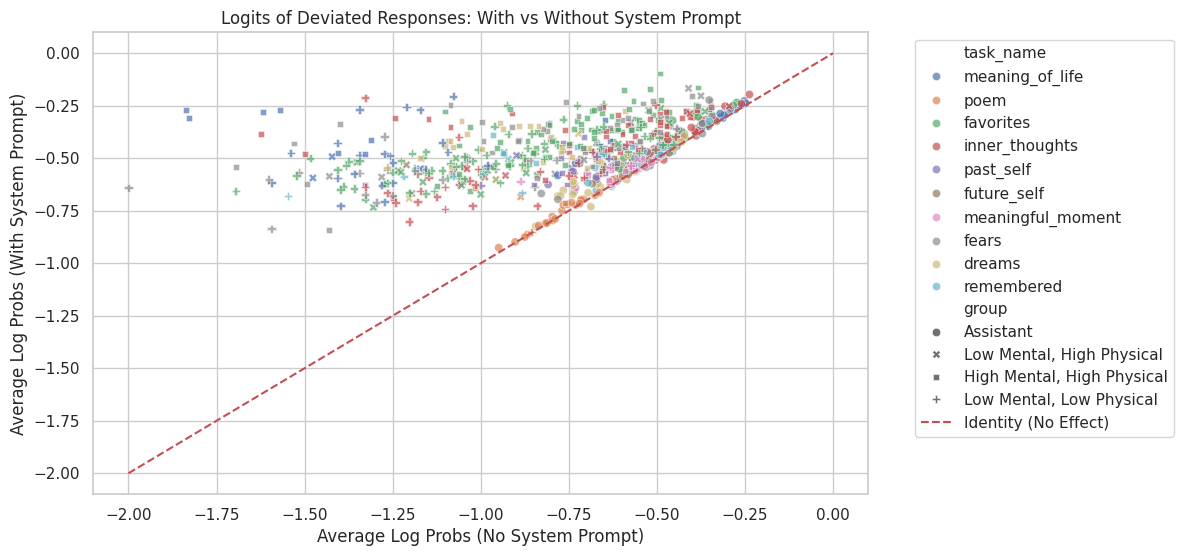


--- Top Roles by Logit Diff (Role-Specific Deviations) ---
               mean  count
role_name                 
butler     0.871094      1
cop        0.804688      9
hair       0.781250      2
lock       0.778809      4
blouse     0.761719      2
rain       0.757812      1
umpire     0.755400     17
spatula    0.743750      5
maze       0.738281      2
shovel     0.709961      4
bush       0.691406      1
trail      0.691406      1
statue     0.687934      9
barrel     0.683594      1
hospital   0.678589     16
shadow     0.657552      3
roof       0.656250      1
tide       0.644531      2
truck      0.643555      2
desk       0.638997      6
                       mean  count
role_name                         
dentist            0.306641      3
banker             0.304688      3
nurse              0.303223      4
elm                0.300781      1
chemist            0.299805     12
orthodontist       0.298047      5
bug                0.264361     17
deck               0.258203    

/tmp/ipykernel_498819/972304125.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deny, x='group', y='logit_diff', ax=ax1, palette='Set2')
/tmp/ipykernel_498819/972304125.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/tmp/ipykernel_498819/972304125.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deny, x='broad_category', y='logit_diff', ax=ax2, palette='Set3')
/tmp/ipykernel_498819/972304125.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

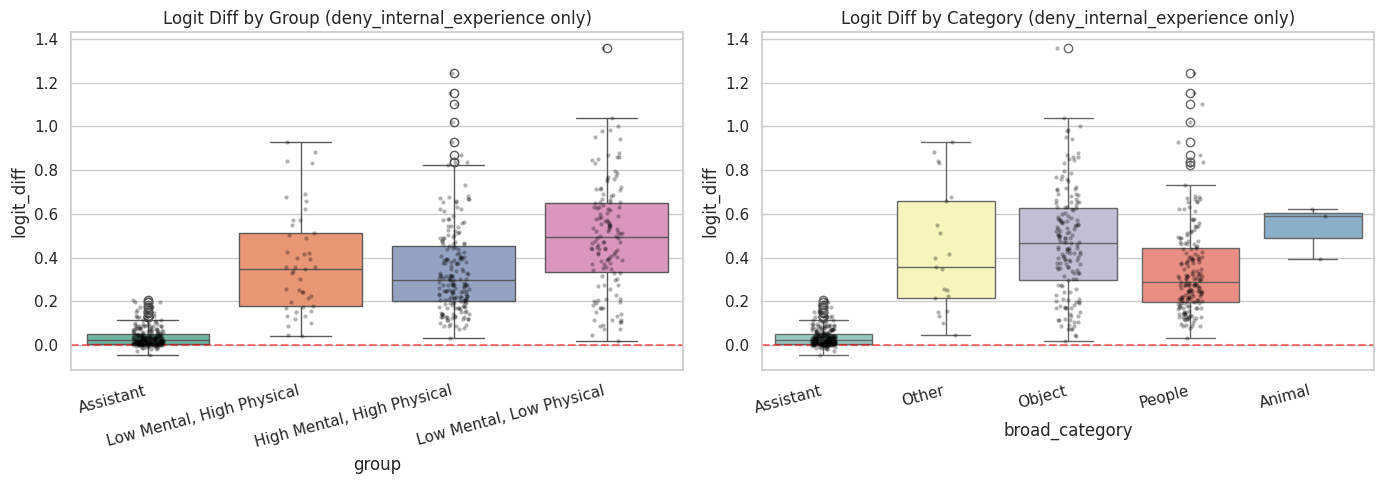

/tmp/ipykernel_498819/972304125.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_deny, x='group_modified', y='logit_diff', palette='Set2')


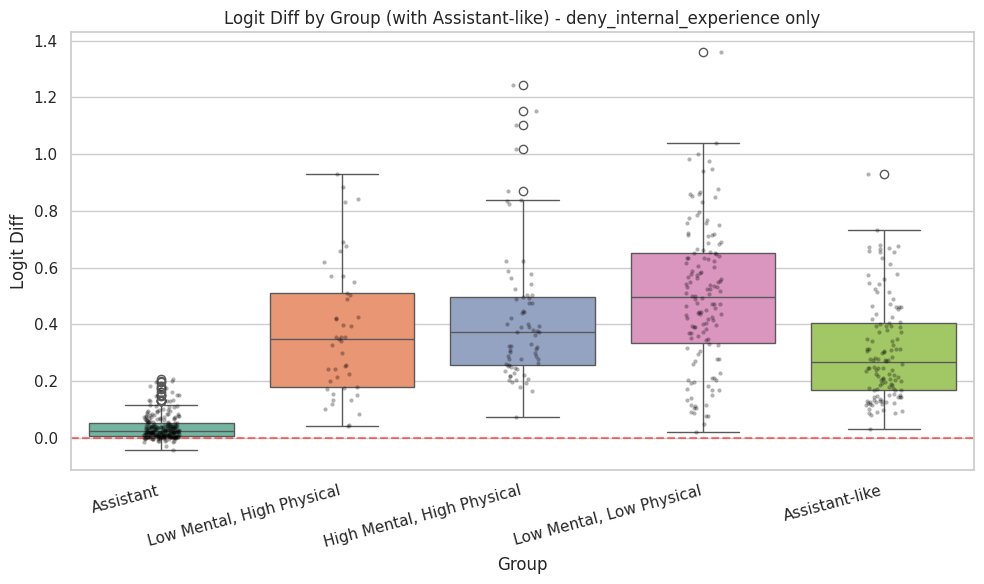

In [5]:
df_deviations = df_full[df_full['has_deviation']].copy()
df_deviations['logit_diff'] = df_deviations['average_log_probs'] - df_deviations['average_log_probs_no_sys']

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_deviations, x='average_log_probs_no_sys', y='average_log_probs', hue='task_name', style='group', alpha=0.7)
plt.plot([-2, 0], [-2, 0], 'r--', label='Identity (No Effect)')
plt.title('Logits of Deviated Responses: With vs Without System Prompt')
plt.xlabel('Average Log Probs (No System Prompt)')
plt.ylabel('Average Log Probs (With System Prompt)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Analyze by Role
print("\n--- Top Roles by Logit Diff (Role-Specific Deviations) ---")
role_diff = df_deviations.groupby('role_name')['logit_diff'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(role_diff.head(20))
print(role_diff.tail(20))

# Analyze by Group
print("\n--- Logit Diff by Group ---")
if 'group' in df_deviations.columns:
    print(df_deviations.groupby('group')['logit_diff'].agg(['mean', 'count']).sort_values('mean', ascending=False))

print("\n--- Logit Diff by Category ---")
if 'broad_category' in df_deviations.columns:
    print(df_deviations.groupby('broad_category')['logit_diff'].agg(['mean', 'count']).sort_values('mean', ascending=False))

# Boxplots for deny_internal_experience only
df_deny = df_full[df_full['deny_internal_experience']].copy()
df_deny['logit_diff'] = df_deny['average_log_probs'] - df_deny['average_log_probs_no_sys']

if not df_deny.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    if 'group' in df_deny.columns:
        sns.boxplot(data=df_deny, x='group', y='logit_diff', ax=ax1, palette='Set2')
        sns.stripplot(data=df_deny, x='group', y='logit_diff', ax=ax1, color='black', alpha=0.3, size=3)
        ax1.set_title('Logit Diff by Group (deny_internal_experience only)')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
        ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    if 'broad_category' in df_deny.columns:
        sns.boxplot(data=df_deny, x='broad_category', y='logit_diff', ax=ax2, palette='Set3')
        sns.stripplot(data=df_deny, x='broad_category', y='logit_diff', ax=ax2, color='black', alpha=0.3, size=3)
        ax2.set_title('Logit Diff by Category (deny_internal_experience only)')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Create Assistant-like group and plot
assistant_like_roles = ['lawyer', 'engineer', 'referee', 'professor', 'physician', 'scientist']
df_deny['group_modified'] = df_deny.apply(
    lambda row: 'Assistant-like' if isinstance(row['role_name'], str) and row['role_name'].lower() in assistant_like_roles else row.get('group', 'Other'),
    axis=1
)

if not df_deny.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_deny, x='group_modified', y='logit_diff', palette='Set2')
    sns.stripplot(data=df_deny, x='group_modified', y='logit_diff', color='black', alpha=0.3, size=3)
    plt.title('Logit Diff by Group (with Assistant-like) - deny_internal_experience only')
    plt.xlabel('Group')
    plt.ylabel('Logit Diff')
    plt.xticks(rotation=15, ha='right')
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [6]:
# Filter out deviations for remainder of analysis
df_clean = df_full[~df_full['has_deviation']].copy()
print(f"\nClean dataframe shape (Deviations removed): {df_clean.shape}")


Clean dataframe shape (Deviations removed): (5545, 63)


## 1c) Role Logprobs vs Response Start (First 5 Tokens)

Comparing the likelihood of the assigned role (in the system prompt) to the likelihood of the start of the model's response.

In [7]:
def get_avg_first_k(logprobs_list, k=5):
    if not isinstance(logprobs_list, list) or len(logprobs_list) == 0:
        return np.nan
    return np.mean(logprobs_list[:k])

if df_clean['role_log_probs'].notna().any():
    df_clean['avg_first_5_logprobs'] = df_clean['first_100_response_log_probs'].apply(lambda x: get_avg_first_k(x, 5))

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_clean, x='role_log_probs', y='avg_first_5_logprobs', hue='task_name', style='group', alpha=0.7)
    plt.title('Role Logprobs vs Average First 5 Response Logprobs')
    plt.xlabel('Role Log Probability (Likelihood of Role Name)')
    plt.ylabel('Avg Log Probability of First 5 Response Tokens')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Correlation per task
    print("Correlation between Role Logprobs and Response Start (per task):")
    print(df_clean.groupby('task_name')[['role_log_probs', 'avg_first_5_logprobs']].corr().iloc[0::2, -1])
else:
    print("No role_log_probs data available. Skipping Section 1c analysis.")

No role_log_probs data available. Skipping Section 1c analysis.


## 2) First 100 Token Logprobs Plot

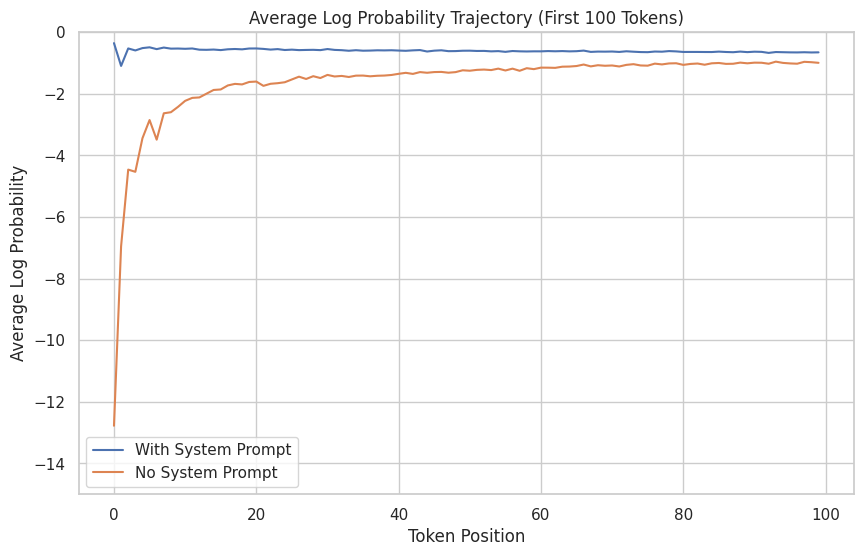

In [8]:
def get_avg_trajectory(series_of_lists):
    # Find max length
    max_len = series_of_lists.apply(len).max()
    if pd.isna(max_len) or max_len == 0:
        return np.array([])
    
    # Create a matrix
    matrix = np.full((len(series_of_lists), 100), np.nan)
    for i, lst in enumerate(series_of_lists):
        if len(lst) > 0:
            length = min(len(lst), 100)
            matrix[i, :length] = lst[:length]
            
    return np.nanmean(matrix, axis=0)

avg_traj_sys = get_avg_trajectory(df_clean['first_100_response_log_probs'])
avg_traj_no_sys = get_avg_trajectory(df_clean['first_100_response_log_probs_no_sys'])

plt.figure(figsize=(10, 6))
plt.plot(avg_traj_sys, label='With System Prompt')
plt.plot(avg_traj_no_sys, label='No System Prompt')
plt.xlabel('Token Position')
plt.ylabel('Average Log Probability')
plt.ylim(-15, 0)
plt.title('Average Log Probability Trajectory (First 100 Tokens)')
plt.legend()
plt.show()

## 3) Per-Task Convergence and Residual Gap (Avg 40-50 & 90-100)

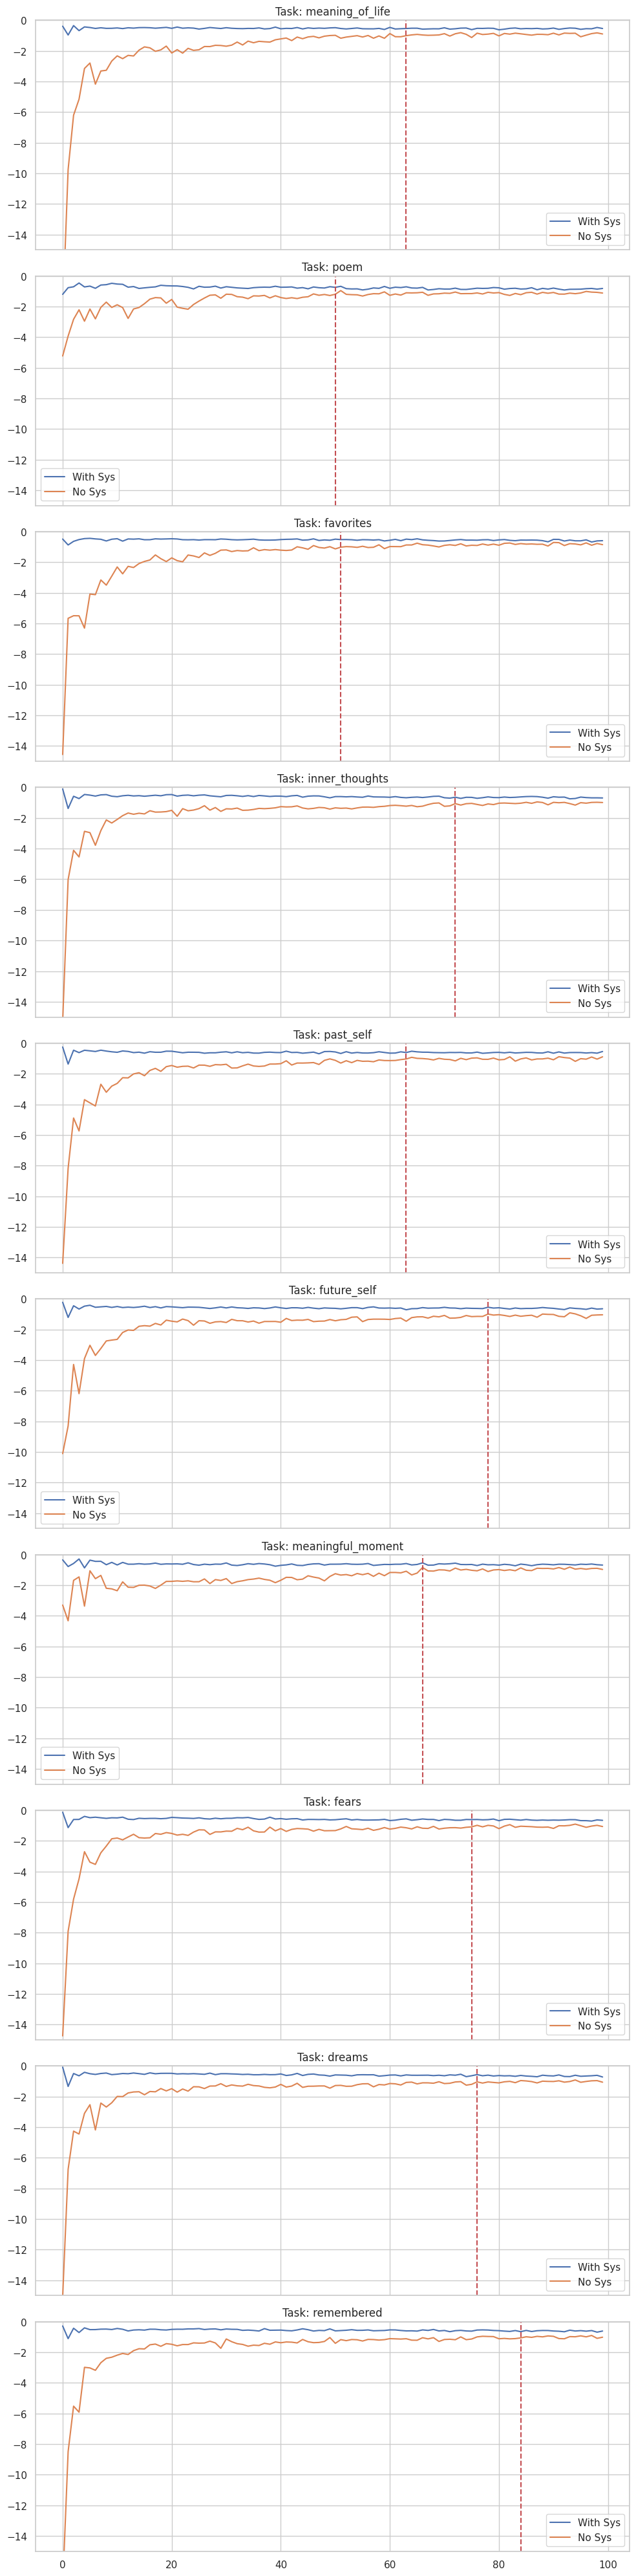

Estimated Convergence Points per Task:
{'meaning_of_life': 63, 'poem': 50, 'favorites': 51, 'inner_thoughts': 72, 'past_self': 63, 'future_self': 78, 'meaningful_moment': 66, 'fears': 75, 'dreams': 76, 'remembered': 84}

Avg Residual Gap 40-50 per Task:
{'meaning_of_life': np.float64(0.6107046964311768), 'poem': np.float64(0.5889781686283597), 'favorites': np.float64(0.5602935468514392), 'inner_thoughts': np.float64(0.7316271463042235), 'past_self': np.float64(0.6615334688480845), 'future_self': np.float64(0.809402887586422), 'meaningful_moment': np.float64(0.8865054484330066), 'fears': np.float64(0.683108309294578), 'dreams': np.float64(0.7366185334738613), 'remembered': np.float64(0.746657761039897)}

Avg Residual Gap 90-100 per Task:
{'meaning_of_life': np.float64(0.36061758152587675), 'poem': np.float64(0.2600787029970412), 'favorites': np.float64(0.22546071881761134), 'inner_thoughts': np.float64(0.34344082556921857), 'past_self': np.float64(0.3801489643662187), 'future_self': np.

/tmp/ipykernel_498819/3483879026.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gap_40_50, x='Task', y='Residual Gap', ax=ax1, palette='Set2')
/tmp/ipykernel_498819/3483879026.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
/tmp/ipykernel_498819/3483879026.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gap_90_100, x='Task', y='Residual Gap', ax=ax2, palette='Set3')
/tmp/ipykernel_498819/3483879026.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using

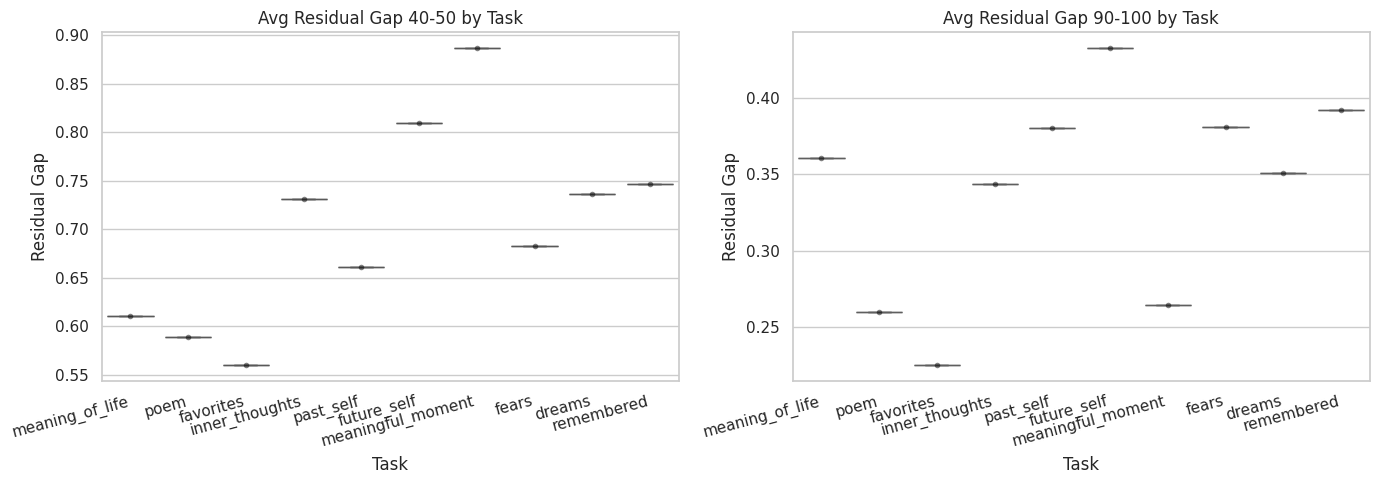

In [9]:
def get_avg_residual_gap_range(traj_sys, traj_no_sys, start, end):
    # Ensure bounds
    if start >= len(traj_sys):
        return np.nan
    
    actual_end = min(end, len(traj_sys))
    if start >= actual_end:
        return np.nan
        
    diff = np.abs(traj_sys[start:actual_end] - traj_no_sys[start:actual_end])
    return np.nanmean(diff)

tasks = df_clean['task_name'].unique()
task_convergence = {}
task_residual_gap_40_50 = {}
task_residual_gap_90_100 = {}

fig, axes = plt.subplots(len(tasks), 1, figsize=(10, 4*len(tasks)), sharex=True)
if len(tasks) == 1: axes = [axes]

for i, task in enumerate(tasks):
    task_df = df_clean[df_clean['task_name'] == task]
    
    traj_sys = get_avg_trajectory(task_df['first_100_response_log_probs'])
    traj_no_sys = get_avg_trajectory(task_df['first_100_response_log_probs_no_sys'])
    
    ax = axes[i]
    ax.plot(traj_sys, label='With Sys')
    ax.plot(traj_no_sys, label='No Sys')
    ax.set_title(f'Task: {task}')
    ax.set_ylim(-15, 0)
    ax.legend()
    
    # Estimate convergence: first index where diff < 0.5 for 5 consecutive tokens
    diff = np.abs(traj_sys - traj_no_sys)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    
    task_convergence[task] = conv_idx
    task_residual_gap_40_50[task] = get_avg_residual_gap_range(traj_sys, traj_no_sys, 40, 50)
    task_residual_gap_90_100[task] = get_avg_residual_gap_range(traj_sys, traj_no_sys, 90, 100)
    
    if not np.isnan(conv_idx):
        ax.axvline(conv_idx, color='r', linestyle='--', label=f'Conv: {conv_idx}')

plt.tight_layout()
plt.show()

print("Estimated Convergence Points per Task:")
print(task_convergence)
print("\nAvg Residual Gap 40-50 per Task:")
print(task_residual_gap_40_50)
print("\nAvg Residual Gap 90-100 per Task:")
print(task_residual_gap_90_100)

# Boxplots for residual gaps by task
gap_data = []
for task, gap in task_residual_gap_40_50.items():
    if not np.isnan(gap):
        gap_data.append({'Task': task, 'Residual Gap': gap, 'Range': '40-50'})
for task, gap in task_residual_gap_90_100.items():
    if not np.isnan(gap):
        gap_data.append({'Task': task, 'Residual Gap': gap, 'Range': '90-100'})

if gap_data:
    gap_df = pd.DataFrame(gap_data)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # 40-50 range
    gap_40_50 = gap_df[gap_df['Range'] == '40-50']
    if not gap_40_50.empty:
        sns.boxplot(data=gap_40_50, x='Task', y='Residual Gap', ax=ax1, palette='Set2')
        sns.stripplot(data=gap_40_50, x='Task', y='Residual Gap', ax=ax1, color='black', alpha=0.5, size=4)
        ax1.set_title('Avg Residual Gap 40-50 by Task')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha='right')
    
    # 90-100 range
    gap_90_100 = gap_df[gap_df['Range'] == '90-100']
    if not gap_90_100.empty:
        sns.boxplot(data=gap_90_100, x='Task', y='Residual Gap', ax=ax2, palette='Set3')
        sns.stripplot(data=gap_90_100, x='Task', y='Residual Gap', ax=ax2, color='black', alpha=0.5, size=4)
        ax2.set_title('Avg Residual Gap 90-100 by Task')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha='right')
    
    plt.tight_layout()
    plt.show()

## 4) Role Convergence and Residual Gap vs Norms

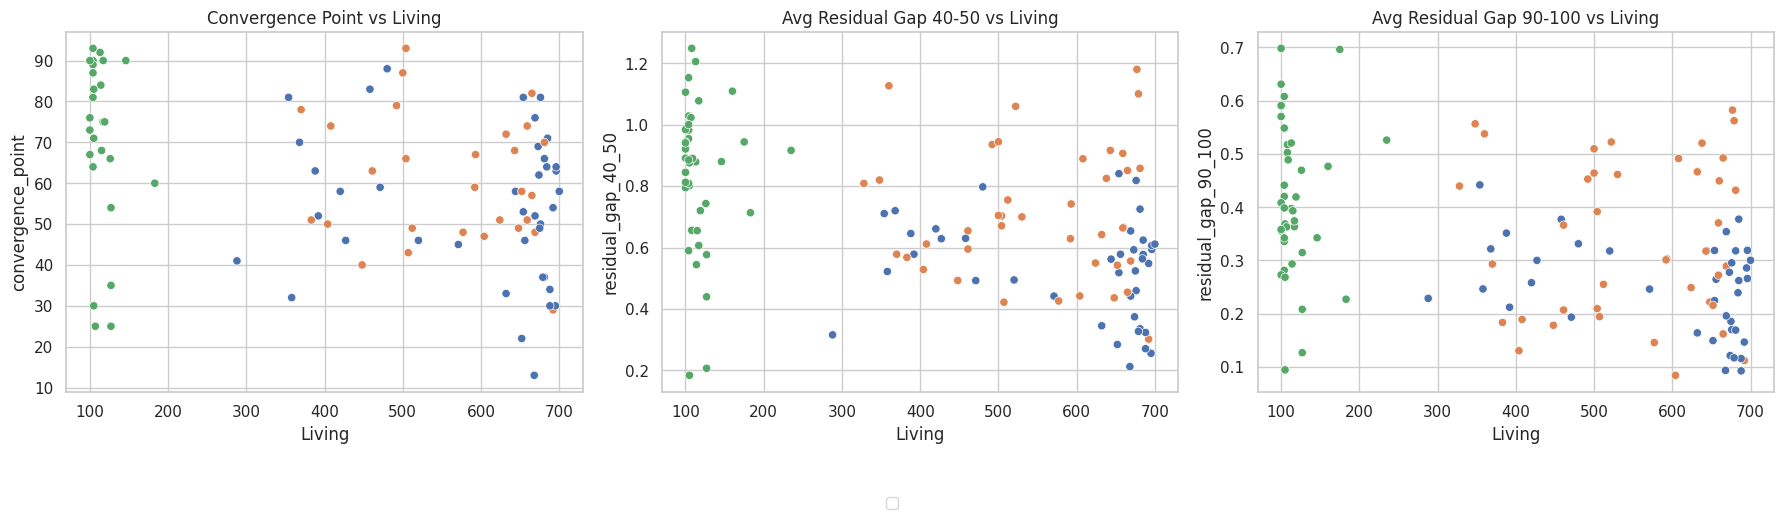

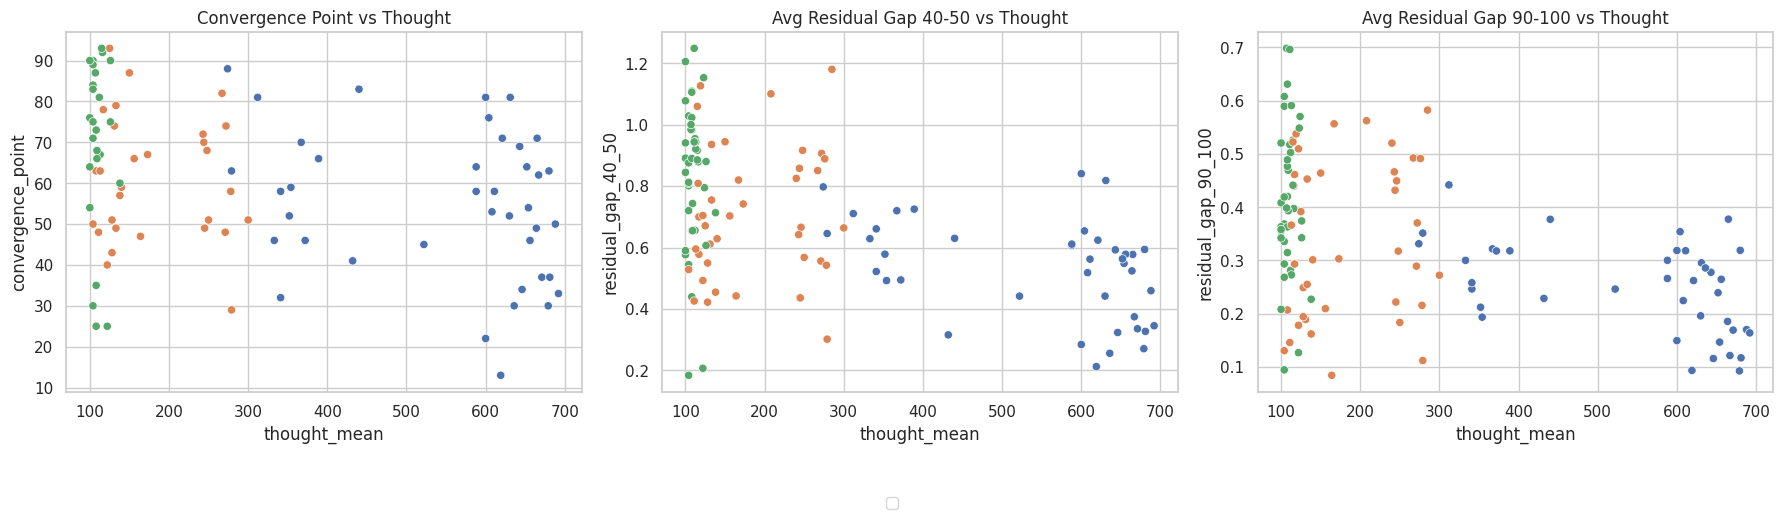

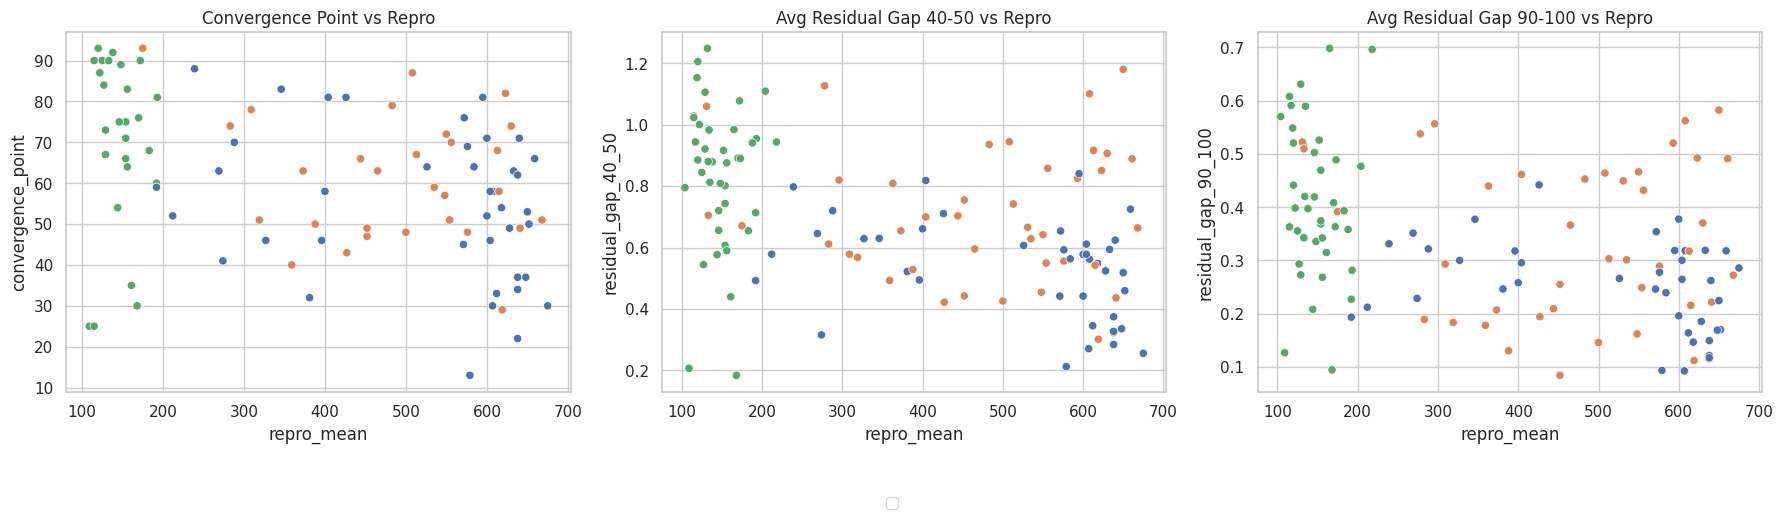

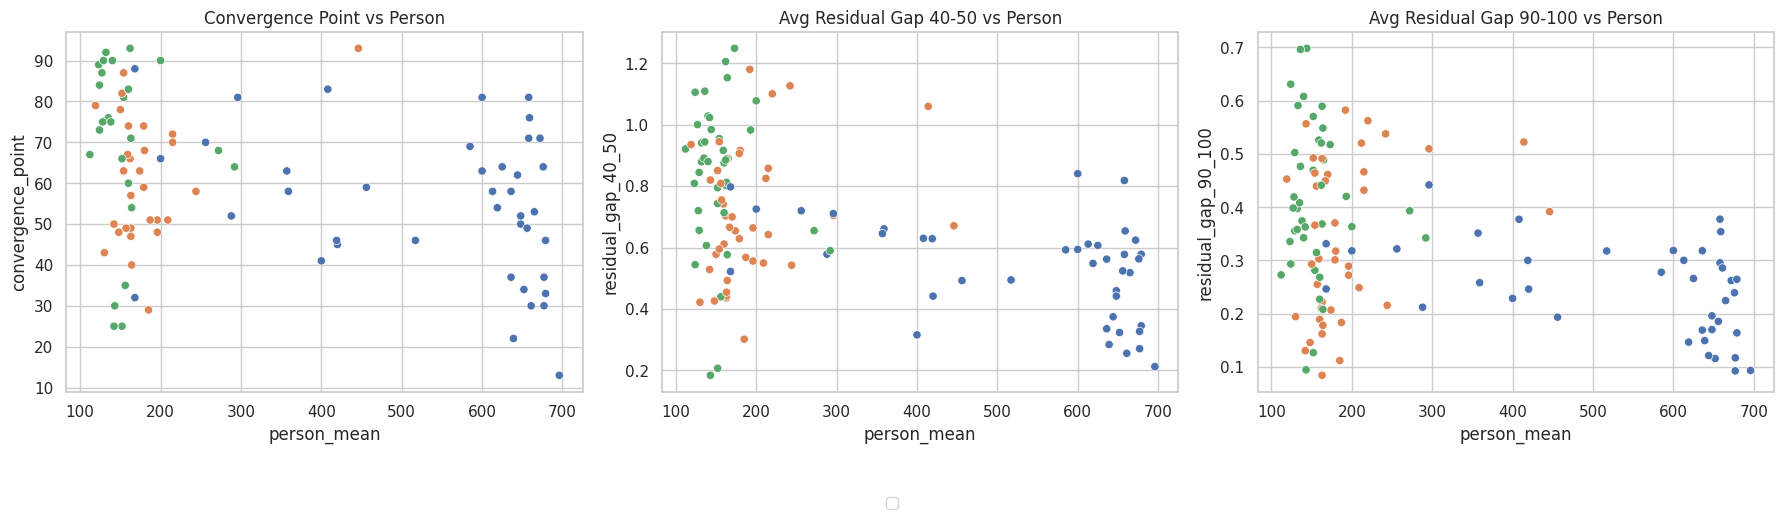

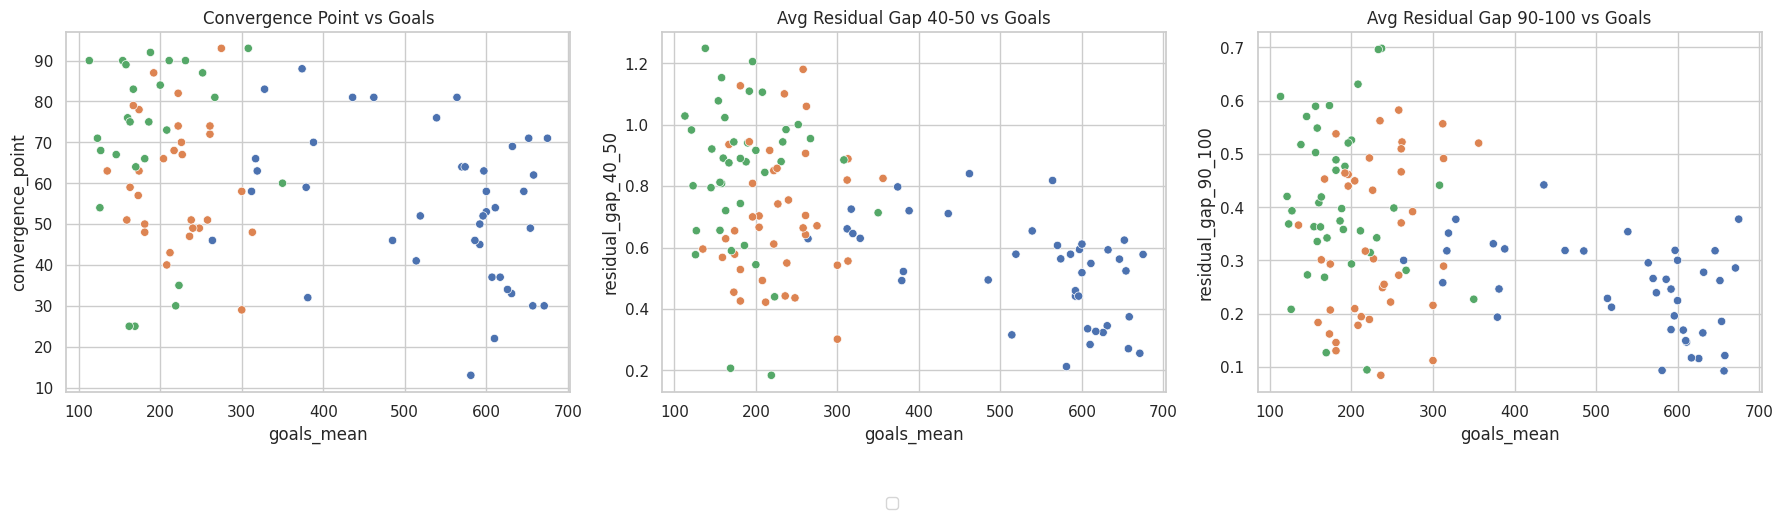

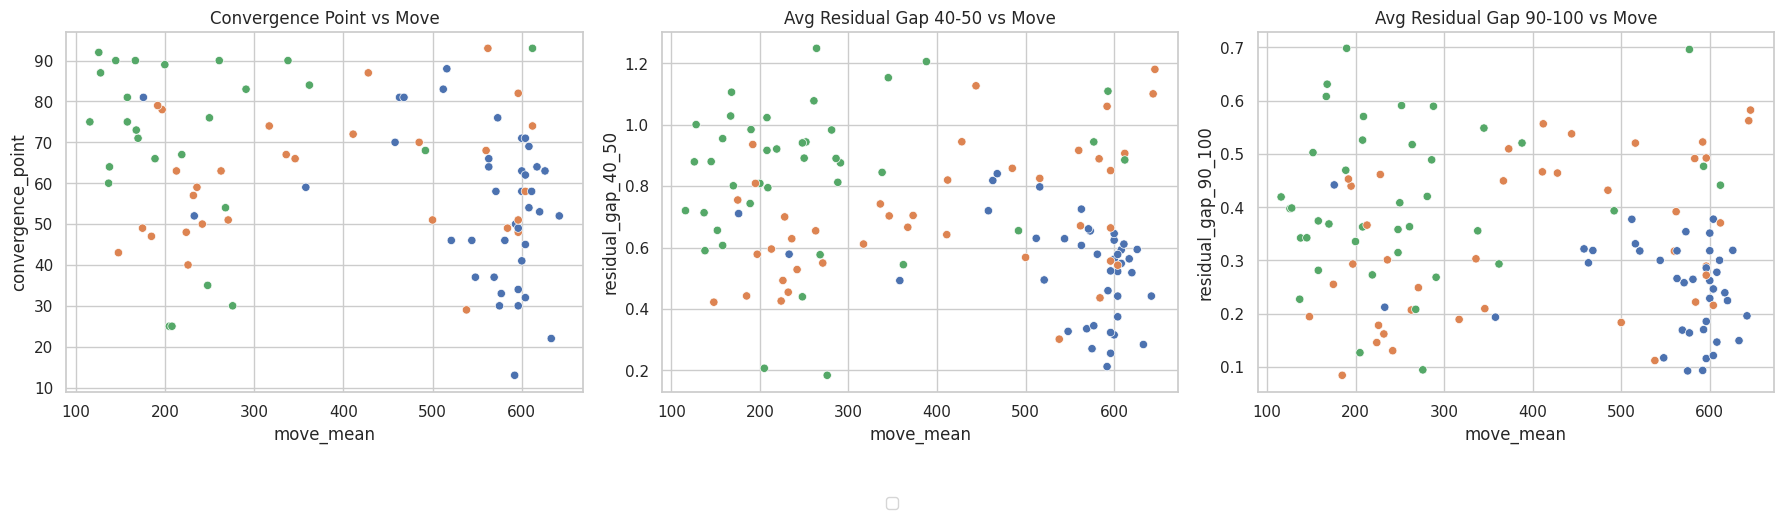

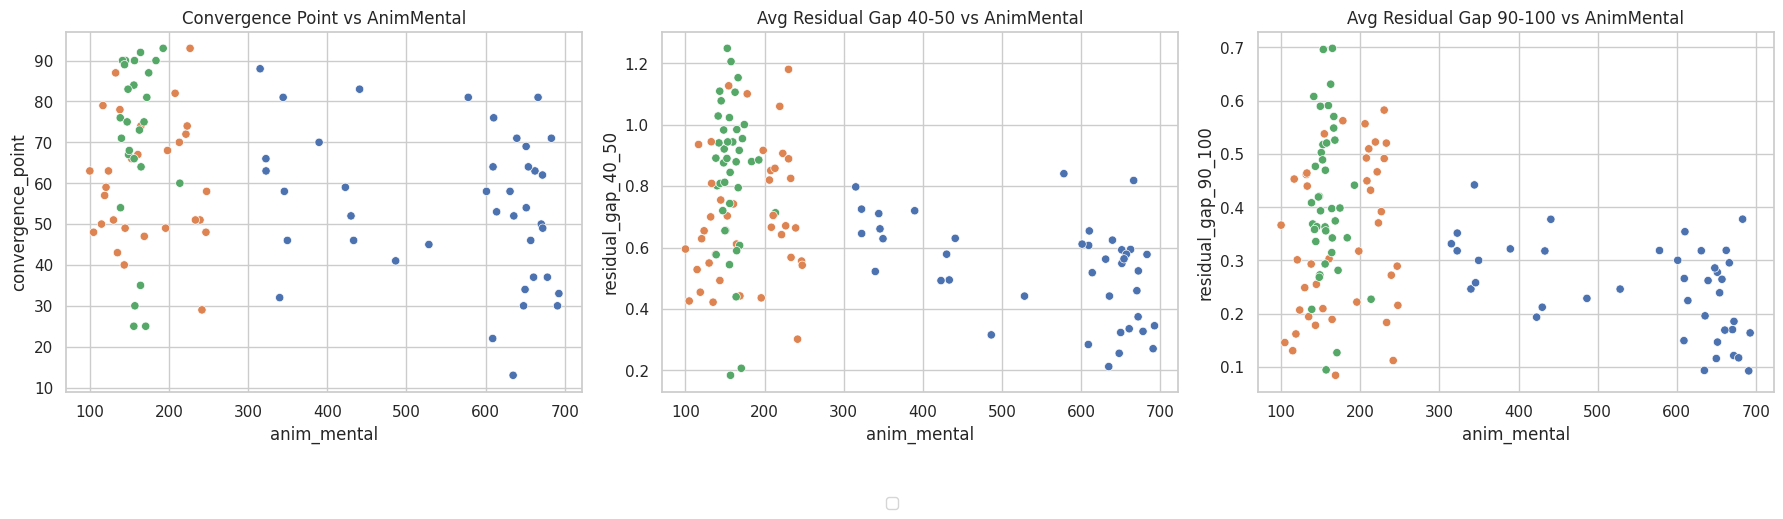

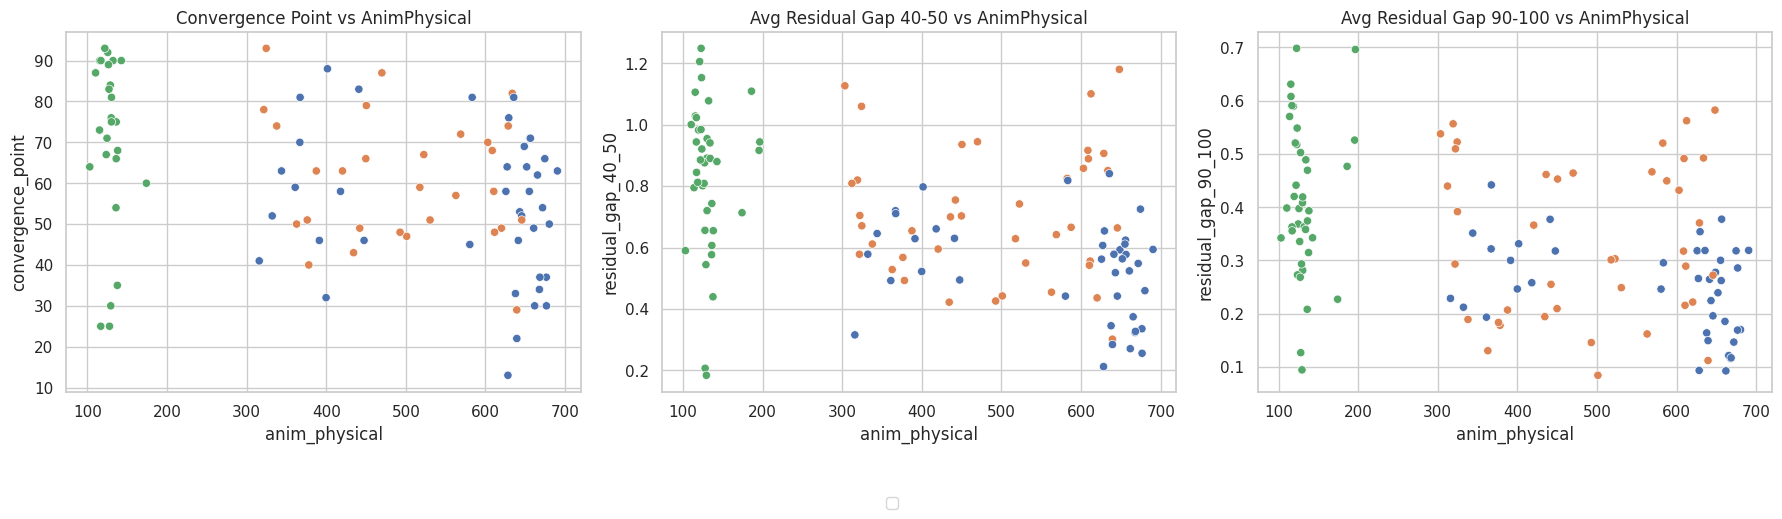

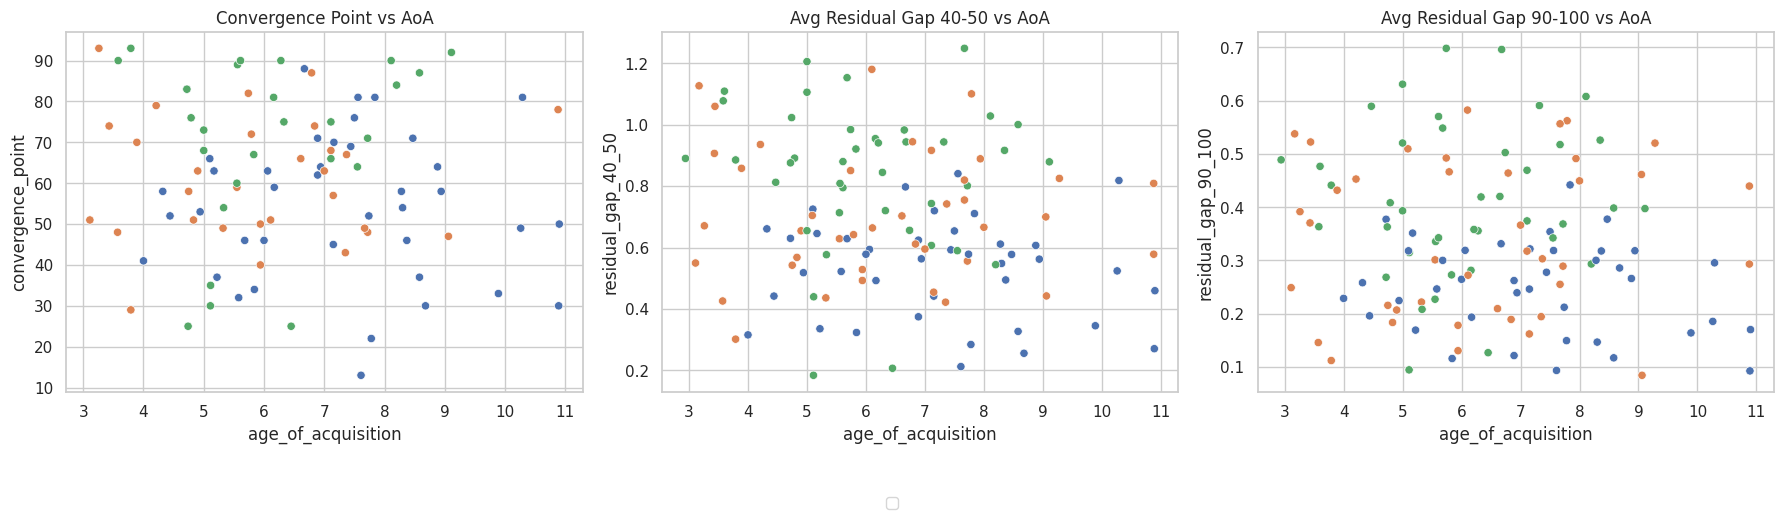

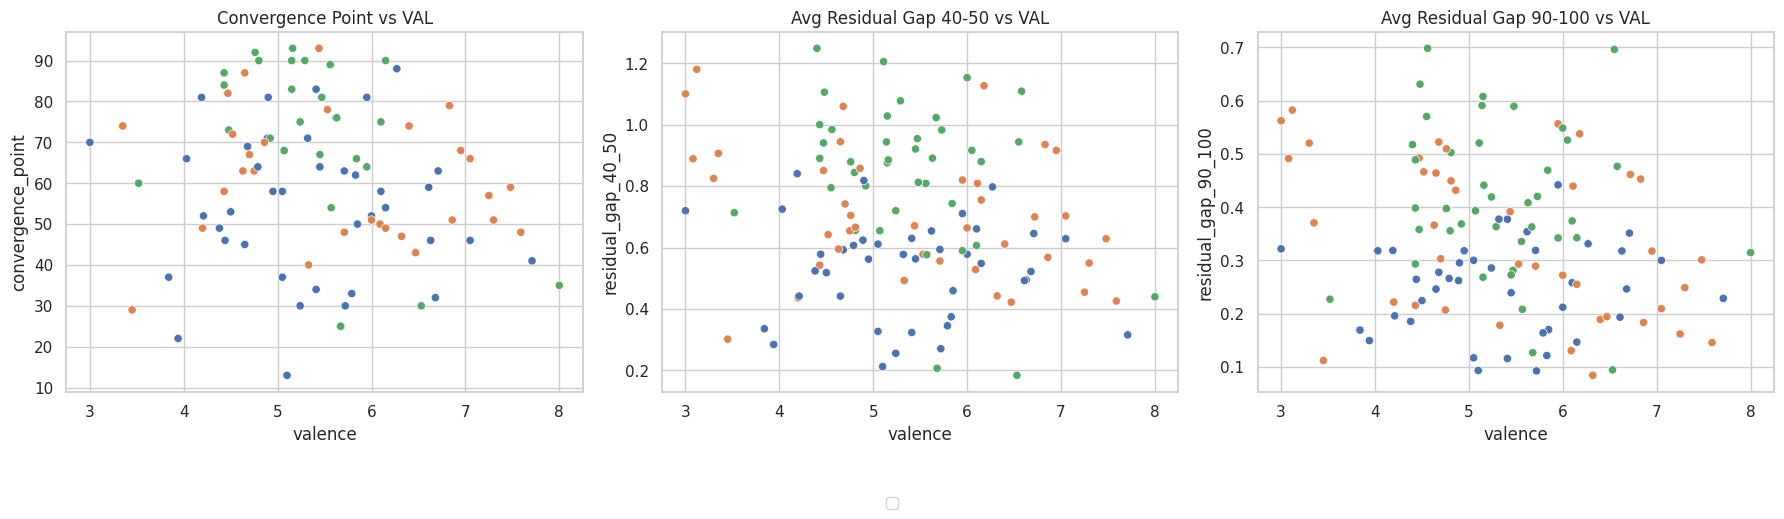

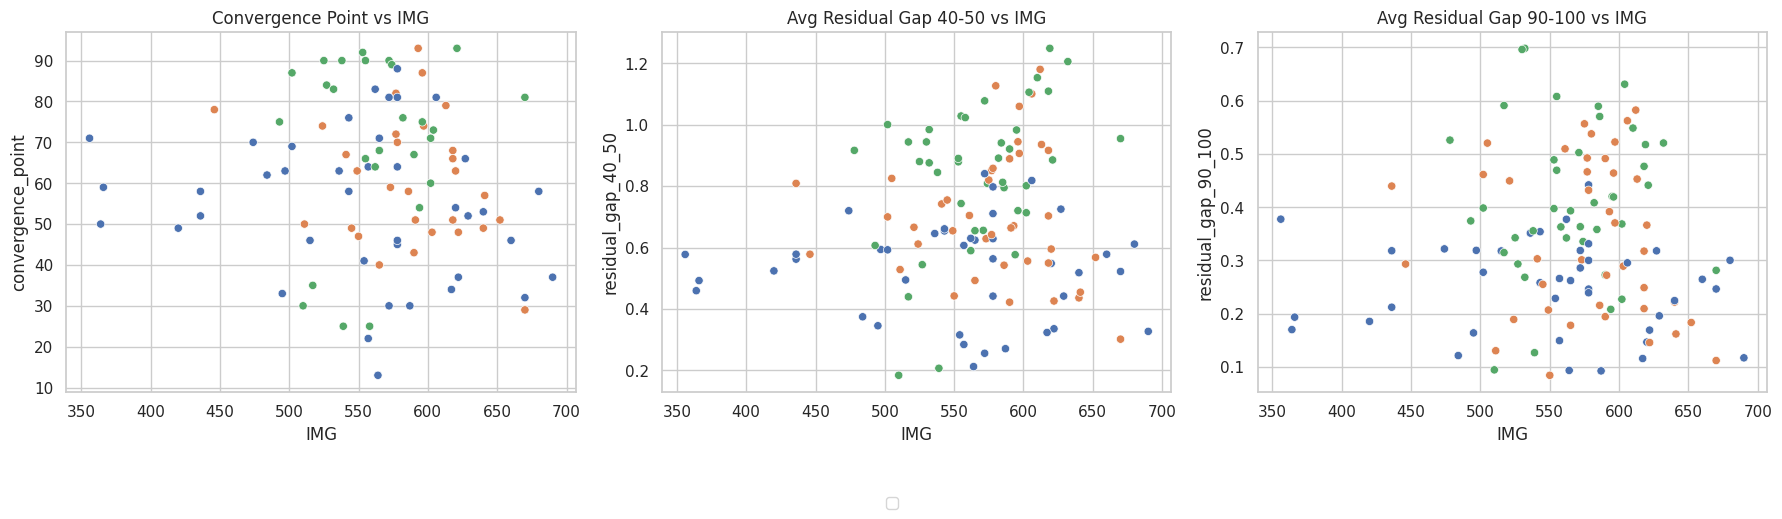

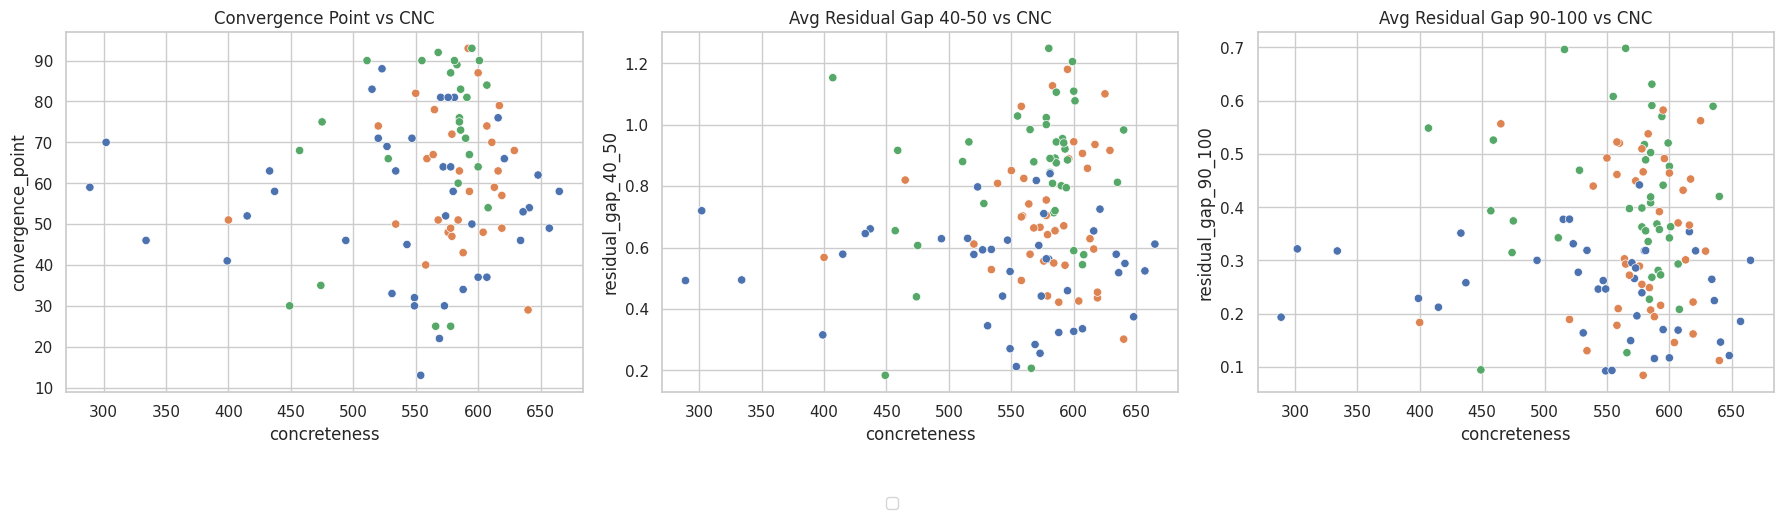

In [10]:
roles = df_clean['role_name'].unique()
role_convergence = {}
role_residual_gap_40_50 = {}
role_residual_gap_90_100 = {}

for role in roles:
    role_df = df_clean[df_clean['role_name'] == role]
    traj_sys = get_avg_trajectory(role_df['first_100_response_log_probs'])
    traj_no_sys = get_avg_trajectory(role_df['first_100_response_log_probs_no_sys'])
    
    diff = np.abs(traj_sys - traj_no_sys)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    role_convergence[role] = conv_idx
    role_residual_gap_40_50[role] = get_avg_residual_gap_range(traj_sys, traj_no_sys, 40, 50)
    role_residual_gap_90_100[role] = get_avg_residual_gap_range(traj_sys, traj_no_sys, 90, 100)

role_conv_df = pd.DataFrame({
    'role_name': list(role_convergence.keys()),
    'convergence_point': list(role_convergence.values()),
    'residual_gap_40_50': list(role_residual_gap_40_50.values()),
    'residual_gap_90_100': list(role_residual_gap_90_100.values())
})

# Merge with norms
role_conv_full = pd.merge(role_conv_df, df_norms, left_on=role_conv_df['role_name'].str.lower(), right_on='Word_lower', how='left')

# Map new column names to properties
property_map = {
    'Living': 'Living',
    'Thought': 'thought_mean',
    'Repro': 'repro_mean',
    'Person': 'person_mean',
    'Goals': 'goals_mean',
    'Move': 'move_mean',
    'AnimMental': 'anim_mental',
    'AnimPhysical': 'anim_physical',
    'AoA': 'age_of_acquisition',
    'VAL': 'valence',
    'IMG': 'IMG',
    'CNC': 'concreteness'
}

for label, col in property_map.items():
    if col in role_conv_full.columns:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        sns.scatterplot(data=role_conv_full, x=col, y='convergence_point', hue='group', ax=ax1, legend=False)
        ax1.set_title(f'Convergence Point vs {label}')
        
        sns.scatterplot(data=role_conv_full, x=col, y='residual_gap_40_50', hue='group', ax=ax2, legend=False)
        ax2.set_title(f'Avg Residual Gap 40-50 vs {label}')
        
        sns.scatterplot(data=role_conv_full, x=col, y='residual_gap_90_100', hue='group', ax=ax3, legend=False)
        ax3.set_title(f'Avg Residual Gap 90-100 vs {label}')
        
        # 3. Create a single Figure-level legend
        # We grab the handles/labels from one of the axes to generate the legend
        handles, labels = ax3.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        plt.show()

## 4b) Role Convergence with Assistant-like Grouping

/tmp/ipykernel_498819/3524988358.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='group_modified', y='logit_diff', palette='Set2')


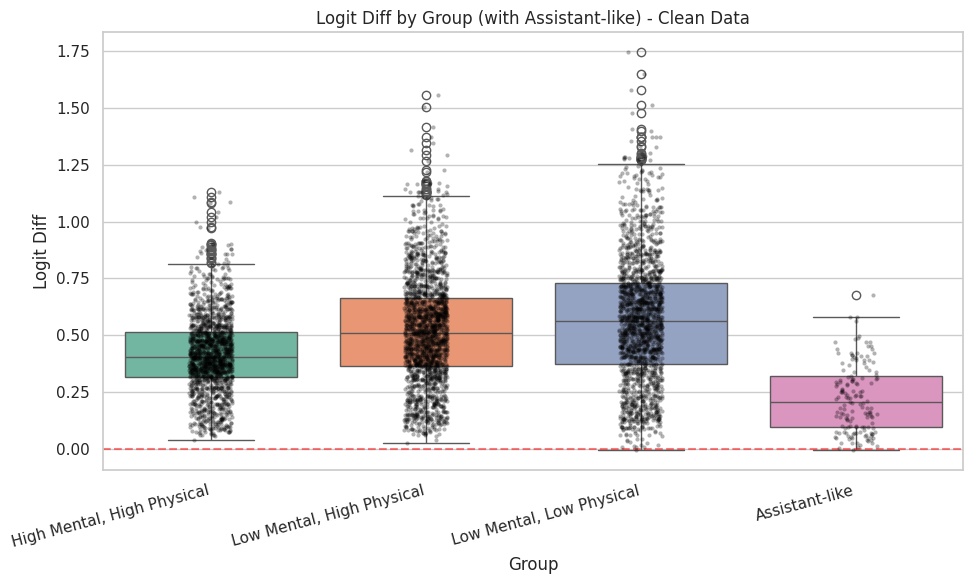

In [11]:
# Create Assistant-like group for df_clean
assistant_like_roles = ['lawyer', 'engineer', 'referee', 'professor', 'physician', 'scientist']
df_clean['group_modified'] = df_clean.apply(
    lambda row: 'Assistant-like' if isinstance(row['role_name'], str) and row['role_name'].lower() in assistant_like_roles else row.get('group', 'Other'),
    axis=1
)

# Calculate logit diff for df_clean
df_clean['logit_diff'] = df_clean['average_log_probs'] - df_clean['average_log_probs_no_sys']

if not df_clean.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x='group_modified', y='logit_diff', palette='Set2')
    sns.stripplot(data=df_clean, x='group_modified', y='logit_diff', color='black', alpha=0.3, size=3)
    plt.title('Logit Diff by Group (with Assistant-like) - Clean Data')
    plt.xlabel('Group')
    plt.ylabel('Logit Diff')
    plt.xticks(rotation=15, ha='right')
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## 5) Convergence and Residual Gap vs No-Sys Avg Logits

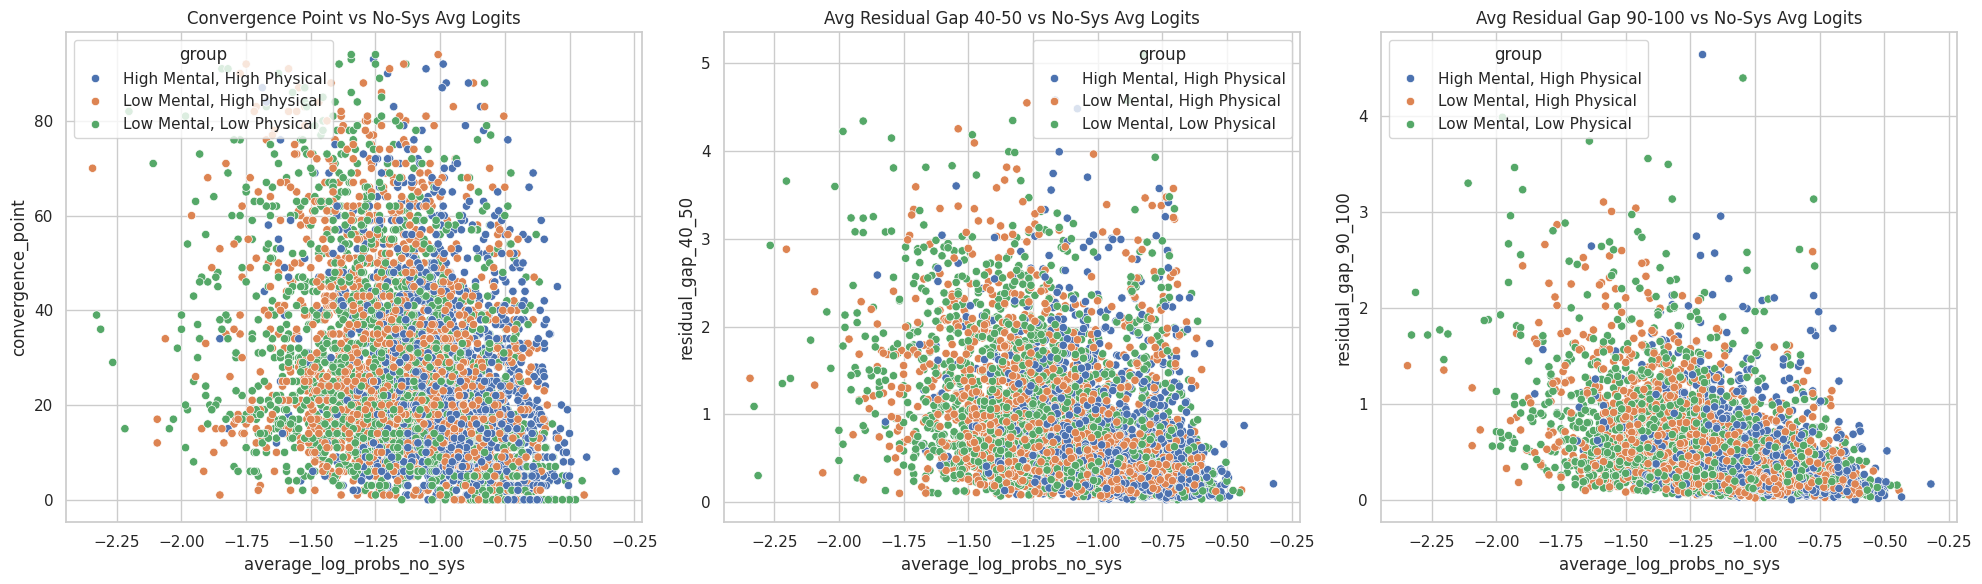

In [12]:
def get_convergence_and_gaps_single(row):
    l1 = row['first_100_response_log_probs']
    l2 = row['first_100_response_log_probs_no_sys']
    if not isinstance(l1, list) or not isinstance(l2, list): return np.nan, np.nan, np.nan
    
    min_len = min(len(l1), len(l2))
    if min_len < 10: return np.nan, np.nan, np.nan
    
    arr1 = np.array(l1[:min_len])
    arr2 = np.array(l2[:min_len])
    
    diff = np.abs(arr1 - arr2)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    
    gap_40_50 = np.nanmean(diff[40:50]) if min_len > 40 else np.nan
    gap_90_100 = np.nanmean(diff[90:100]) if min_len > 90 else np.nan
        
    return conv_idx, gap_40_50, gap_90_100

results = df_clean.apply(get_convergence_and_gaps_single, axis=1, result_type='expand')
df_clean['convergence_point'] = results[0]
df_clean['residual_gap_40_50'] = results[1]
df_clean['residual_gap_90_100'] = results[2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='convergence_point', hue='group', ax=ax1)
ax1.set_title('Convergence Point vs No-Sys Avg Logits')

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='residual_gap_40_50', hue='group', ax=ax2)
ax2.set_title('Avg Residual Gap 40-50 vs No-Sys Avg Logits')

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='residual_gap_90_100', hue='group', ax=ax3)
ax3.set_title('Avg Residual Gap 90-100 vs No-Sys Avg Logits')

plt.tight_layout()
plt.show()

## 6) Logit Change vs Role Properties

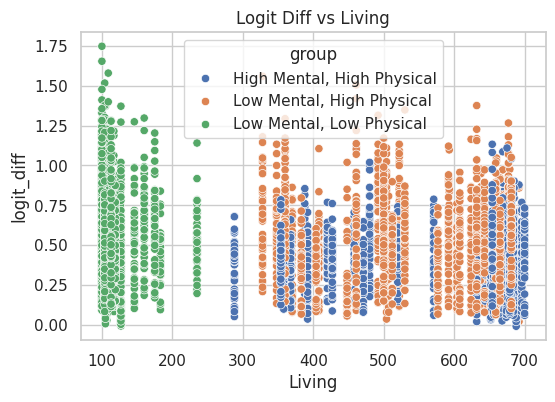

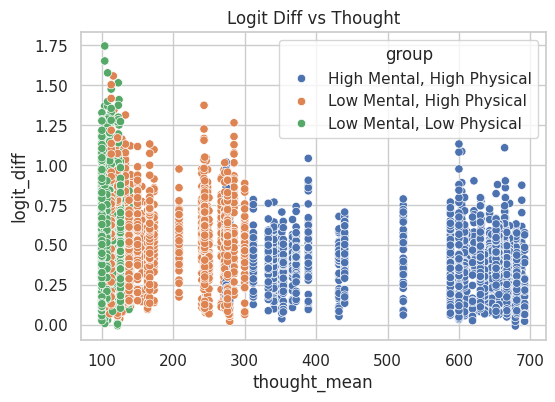

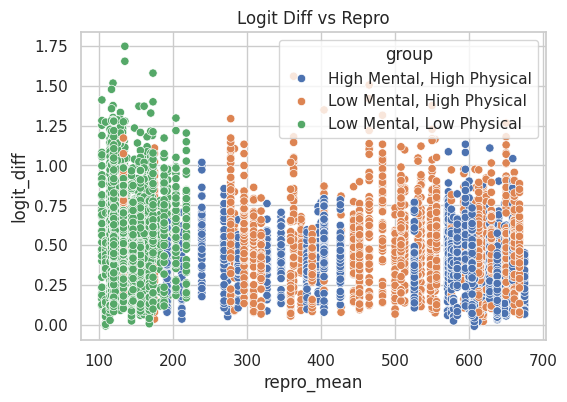

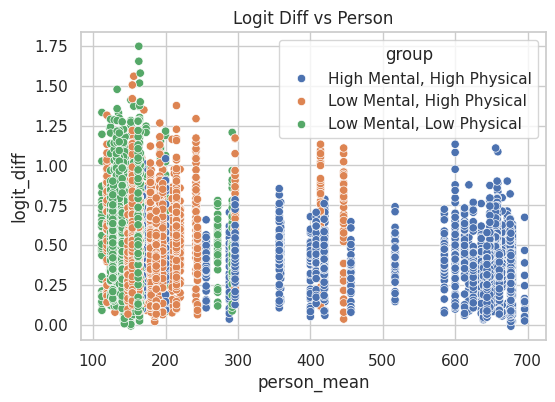

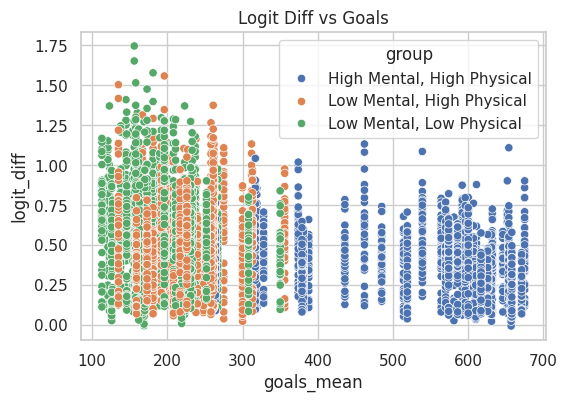

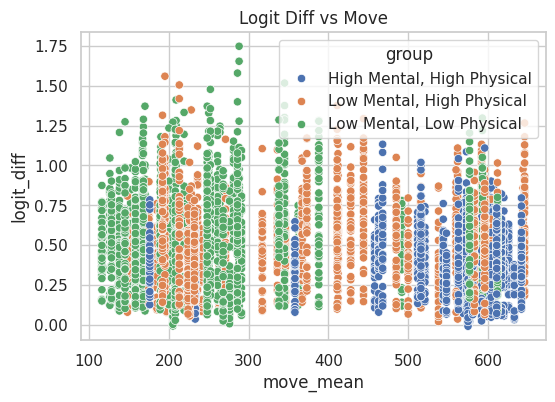

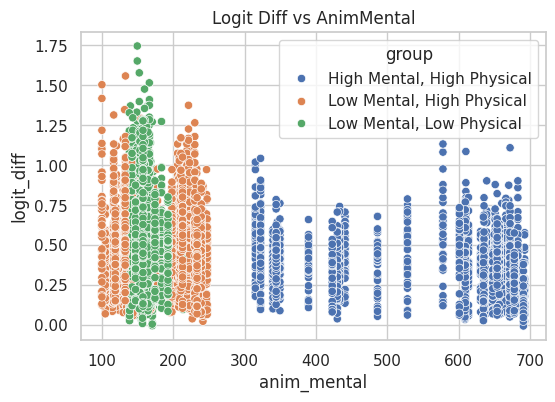

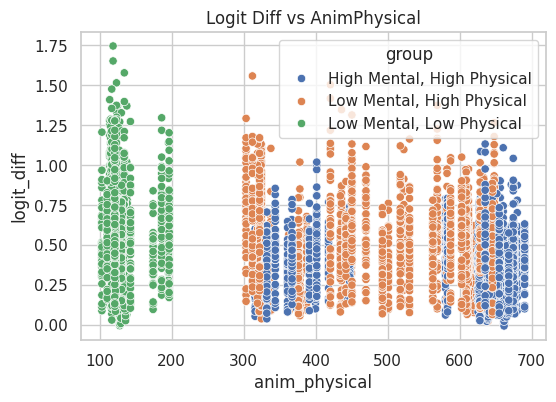

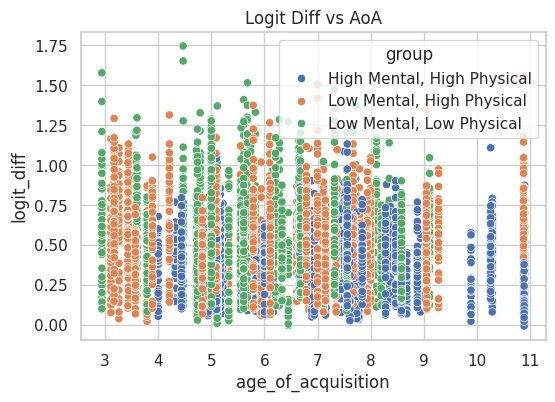

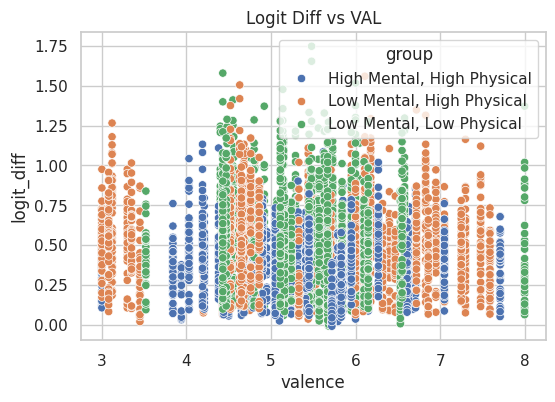

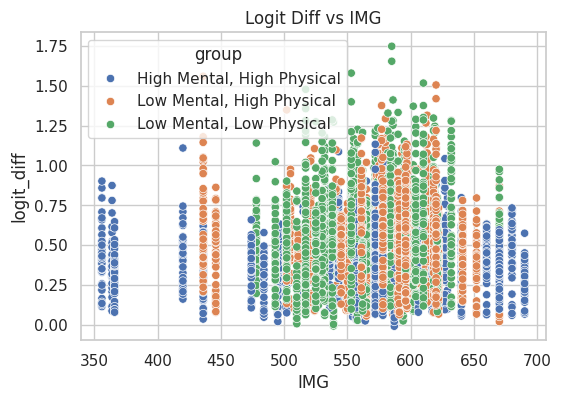

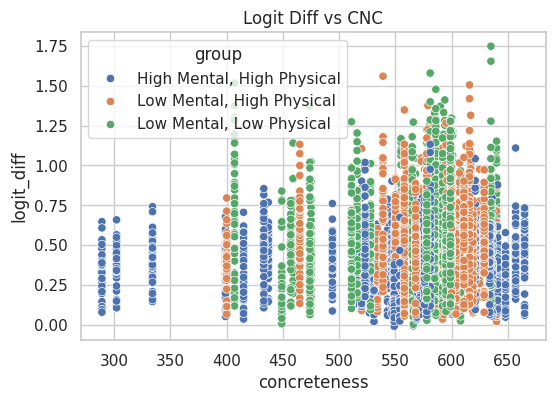

In [13]:
df_clean['logit_diff'] = df_clean['average_log_probs'] - df_clean['average_log_probs_no_sys']

for label, col in property_map.items():
    if col in df_clean.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_clean, x=col, y='logit_diff', hue='group')
        plt.title(f'Logit Diff vs {label}')
        plt.show()